In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as m


# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
from cycler import cycler
COLORS = ['#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler)

# -----------------------------

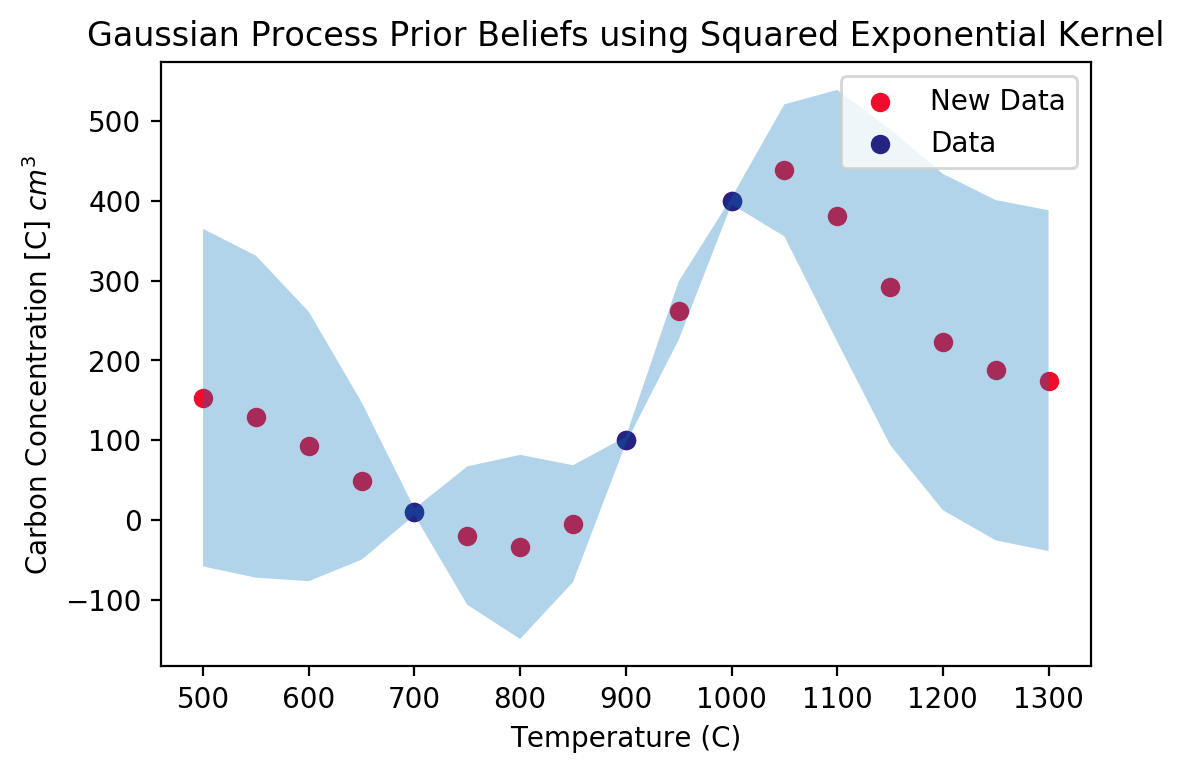

In [73]:
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

T = np.array([700, 900, 1000])
CC = np.array([1e18, 1e19, 4e19]) / 1e17

x_data = T
y_data = CC

#Sigma_n = Covariance matrix
sigma_0 = 178   #Initial uncertainty 
sigma_W = 17 #Initial noise variance 
length_scale = 100 #Initial length scale guess
f_0 = 0 # inital mean

# squared exponential kernel
kernel = sigma_0**2*RBF(length_scale, length_scale_bounds = (100,1e4))

# normalized y confirms mean is = zero

model = GaussianProcessRegressor(kernel = kernel, alpha = sigma_W, normalize_y = True)

# x - sigma values that will be calculated
x_test = np.linspace(500, 1300, 17)

model.fit(x_data[:, np.newaxis], y_data,)

y_test, err = model.predict(x_test[:, np.newaxis], return_std = True)

# Y_test = mean estimate
#err = Std





plt.scatter(x_test, y_test, label = 'New Data')
plt.scatter(x_data,y_data, label='Data')
plt.fill_between(x_test, y_test +err, y_test - err, alpha = .3)
plt.xlabel('Temperature (C)')
plt.ylabel('Carbon Concentration [C] $cm^3$')
plt.title('Gaussian Process Prior Beliefs using Squared Exponential Kernel')
plt.legend()
plt.show()  



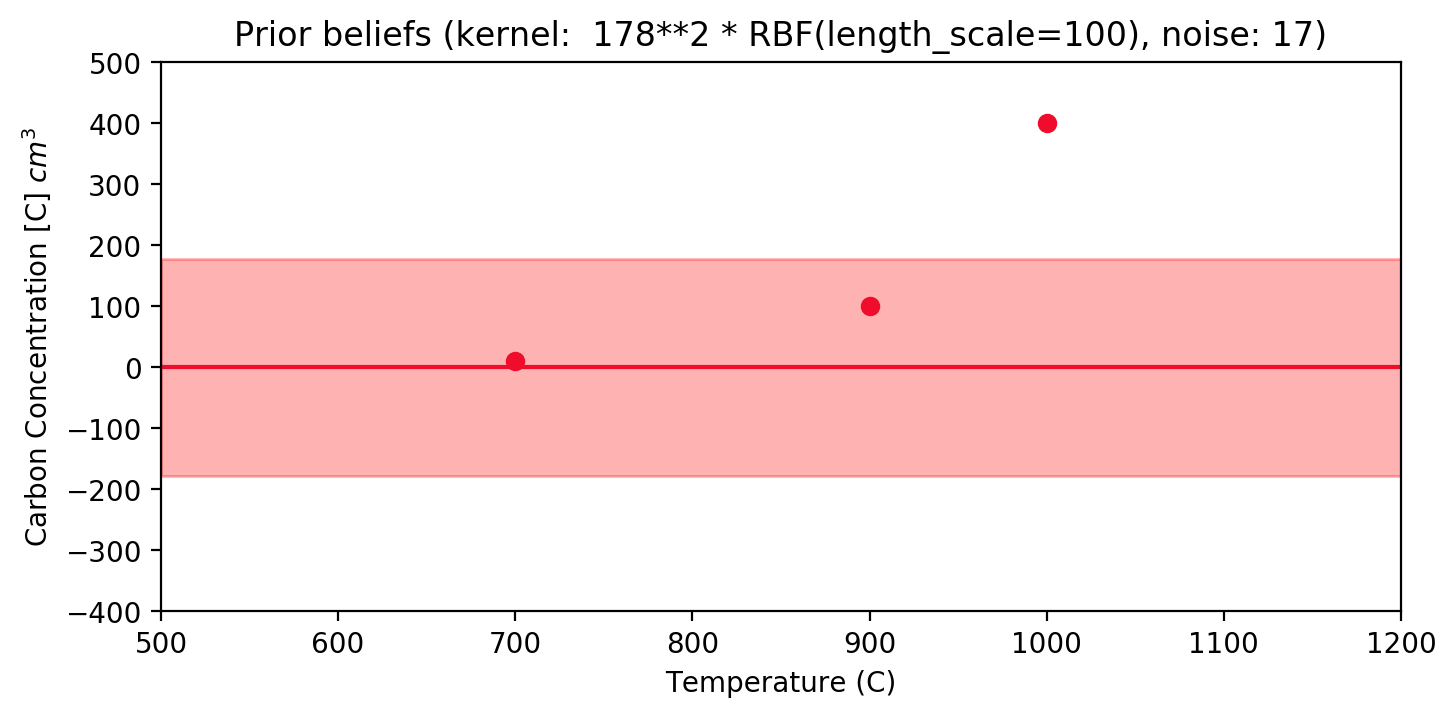

In [57]:
from sklearn.gaussian_process.kernels import RBF
kernels = [sigma_0**2* RBF(length_scale=100, length_scale_bounds=(100, 1e4))]
for kernel in kernels:
    # Specify Gaussian Process
    model = GaussianProcessRegressor(kernel = kernel, alpha = sigma_W, normalize_y = True)

    x_test = np.linspace(500, 1300, 17)

    #model.fit(x_data[:, np.newaxis], y_data)

    y_test, err = model.predict(x_test[:, np.newaxis], return_std = True, )
    
    # Plot prior beliefs - mean = 0 covariance = 178 = sigma_0
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(x_test, y_test)
    plt.fill_between(x_test, y_test - err, y_test + err, alpha=.3, color='r')
    
    y_samples = y_data
    plt.scatter(x_data, y_samples)
    plt.xlim(500, 1200)
    plt.ylim(-400, 500)
    plt.xlabel('Temperature (C)')
    plt.ylabel('Carbon Concentration [C] $cm^3$')
    plt.title("Prior beliefs (kernel:  %s, noise: %s)" %(kernel, model.alpha), fontsize=12)

    # Generate data and fit GP
    #X = x_data
    #y = y_data
    
    
    #model.fit(X[:, np.newaxis], y)


plt.show()


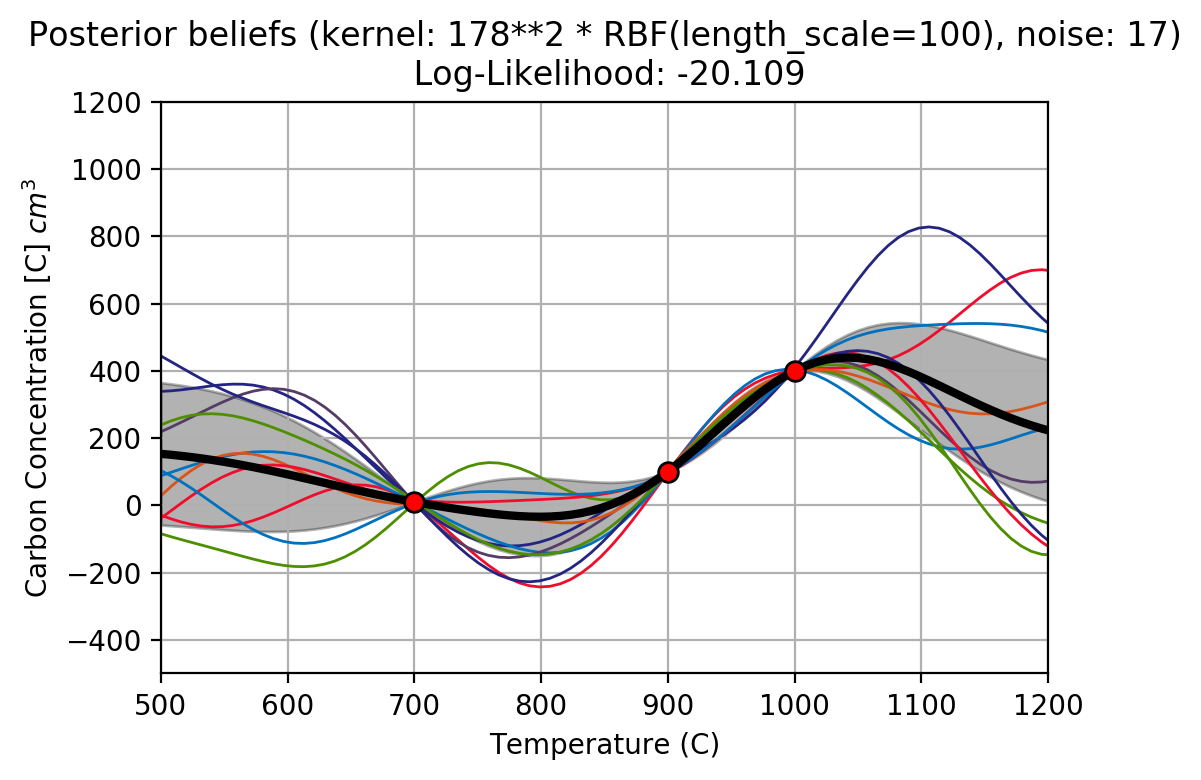

45647.67782024798


In [59]:
from sklearn.gaussian_process.kernels import RBF
kernels = [178**2* RBF(length_scale=100, length_scale_bounds=(100, 1e4))]
for kernel in kernels:
    
    model = GaussianProcessRegressor(kernel = kernel, alpha = sigma_W, normalize_y = True)
        
    # Plot posterior
    X = x_data
    y = y_data
    
    
    x_test = np.linspace(500, 1300, 100)
    plt.grid()
    model.fit(X[:, np.newaxis], y)
    
    #sampling from prior
    y_samples = model.sample_y(x_test[:, np.newaxis], 10)
    
    y_mean, y_std = model.predict(x_test[:, np.newaxis], return_std=True)
    
    plt.plot(x_test, y_samples, lw=1)
    plt.scatter(X, y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.plot(x_test, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(x_test, y_mean - y_std, y_mean + y_std,
                     alpha=0.3, color='k')

    plt.xlim(500, 1200)
    plt.ylim(-500, 1200)
    plt.xlabel('Temperature (C)')
    plt.ylabel('Carbon Concentration [C] $cm^3$')
    plt.title("Posterior beliefs (kernel: %s, noise: %s)\n Log-Likelihood: %.3f"
              % (kernel, model.alpha, model.log_marginal_likelihood(model.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()
y_std = ((y_std)**2)
print(np.max(y_std))


# EI Function

[155.74901968  84.79449831  71.88409912  86.21439667  86.32366711
 126.37071583  68.97524826 157.60860313 205.26852915 262.74038607
 385.5996799  448.86686041 351.73349124 142.27417434 178.69596149
  63.43044484 103.07320787]


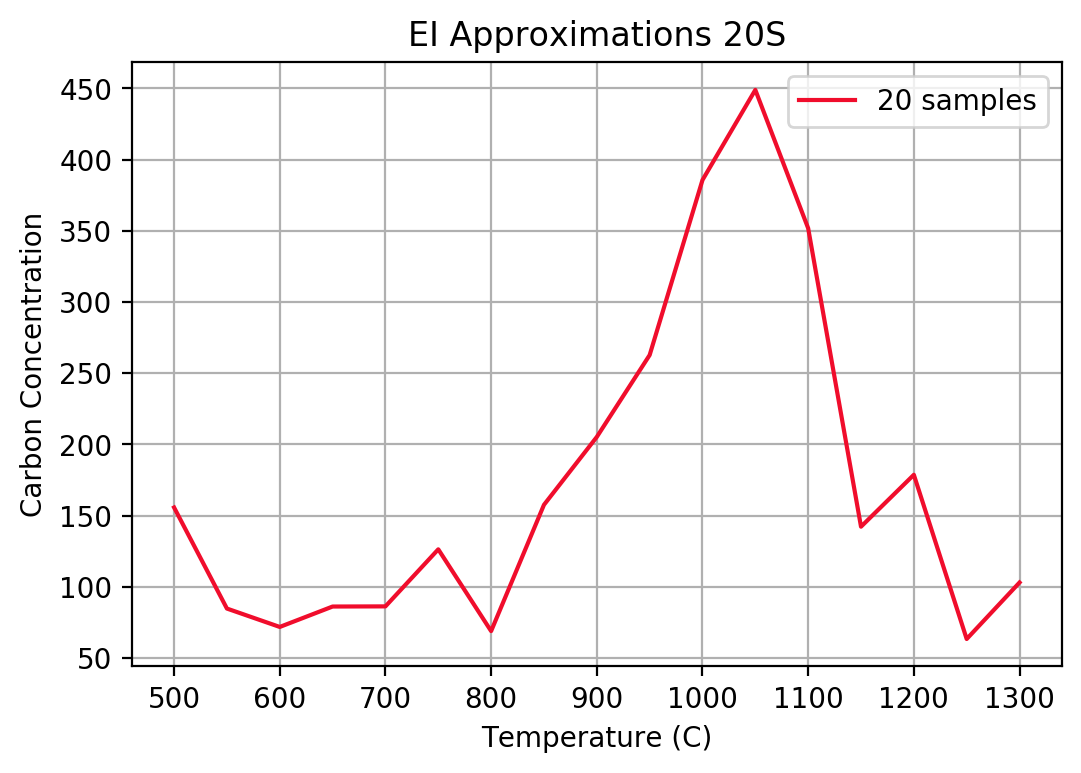

In [67]:
X = x_data
Y = y_data
y_max = 45647

x = np.linspace (500,1300,100)

from scipy.stats import norm

def Q(x,y,y_std):
    #future score calculation
    # Max f_np1 - Max f_n
    
    for i in range (len(x)):
        if y[i] > y_std:
            Q = y[i]-y_std
        else:
            Q = 0
        return Q
        

    #Score of x value from Q
def MCEI_Acquisition_function(x, B_n, y_std, num_mc_samples):
    score = np.zeros(len(x))
    for t in range(len(x)):
        all_q_values = []
        for i in range(num_mc_samples):
            y_mean, y_std = B_n.predict(x[t, np.newaxis, np.newaxis], return_std=True)
            f_star = np.random.normal(y_mean, y_std)
            W = np.random.normal(0,sigma_W**2)
            y = f_star + W
        
            q = Q(x, y, y_std)
        
            all_q_values.append(q)
        
        score[t] = np.mean(all_q_values)
        
    return score

score = np.zeros(20)
TR1 = np.linspace(500,1300,17)
score = MCEI_Acquisition_function(TR1, model,400, 20) # ground truth F-Star
    
plt.xlabel('Temperature (C)')
plt.ylabel('Carbon Concentration')
plt.title('EI Approximations 20S')
plt.plot(TR1,score,label ='20 samples')
plt.legend()
plt.grid()


print(score)



In [68]:
def update(B_n, x_n, obvs):
    B_n = updates(B_n, x_n, obvs)
    
    return x_n , obvs

In [ ]:
# Simulation
#Ei Policy
# loop over policy

# Data GP
B_0 = model


# for policy in policies:(B_n, f_truth)  
#for policy in policies:
    
oc = np.zeros([10, 20])
MSE = np.zeros([10,20])
num_mc_samples = 10
updates = np.zeros([10,20])

        # simulation loop
for s in range(10):
        x_test = np.linspace(500,1300,100)
        B_n = B_0
        sigma_n = sigma_0
        y_max = 45647
        all_y = np.zeros(23)
        all_x = np.zeros(23)
        all_y[0]= 1e18/1e17
        all_y[1] =1e19/1e17
        all_y[2] =4e19/1e17
        all_x[0] =700
        all_x[1]= 900
        all_x[2]= 1000
        
        # Ground truth from prior
        # sampling a function from posterior GP

        f_truth = model.sample_y(x_test[:, np.newaxis], 1)
        True_max = np.max(f_truth)
        #print(True_max)

            # at each step calculating the opportunuity cost
            #performance = np.zeros(20) 


            # campaign loop: loop over experiments

        for n in range (20):
            # finding ground truths from prior data
                f_n = B_n.predict(x_test[:, np.newaxis])
                all_B_n= []
                x_star_n = np.argmax(f_n)
                #print(x_star_n)
                
               
                # Opportunity cost function
                oc[s, n] = np.abs((True_max - f_truth[x_star_n])/True_max)
               
                #MSE function
                MSE[s, n] = np.mean((f_n- f_truth)**2)
                
                
                

                # using Max Variance function to get max score - policy
                
                Max_Variance = MCEI_Acquisition_function(x, B_n, y_std, num_mc_samples)
                x_n = np.argmax(Max_Variance)
                #print(x_n)
               
            
              

                # Calculate policy performance metrics:
                # MSE - global
                # opportunity cost
                #performace1[s, n] = Calculate_performace(B_n , F_truth)
                #performace2[s, n] = Calculate_performace(B_n , F_truth)

            # Experiment
                obvs = f_truth[x_n] + np.random.normal(0,sigma_n)
                if obvs > y_max:
                    y_max = obvs
                all_x[n+3] = x_n
                all_y[n+3] = obvs
                 
                
                B_n = GaussianProcessRegressor(kernel = kernel, alpha = sigma_W, normalize_y = True)
                
                
                
                B_n.fit(all_x[:n+3+1, np.newaxis], all_y[:n+3+1])
                


        
print(x_n)
print(obvs)

                    
            # update beliefs based on the GP
                #B_n = updates(B_n, x_n, obvs)
                
                # 1 new point appended
                #all_B_n.append(x_n)
                
                #all_B_n.append(obvs)
                
                
                # new model fit
                
    # average performace will have length 20 - average performace at each step
#B_n.fit(X[:, np.newaxis], y),(x_n,obvs)

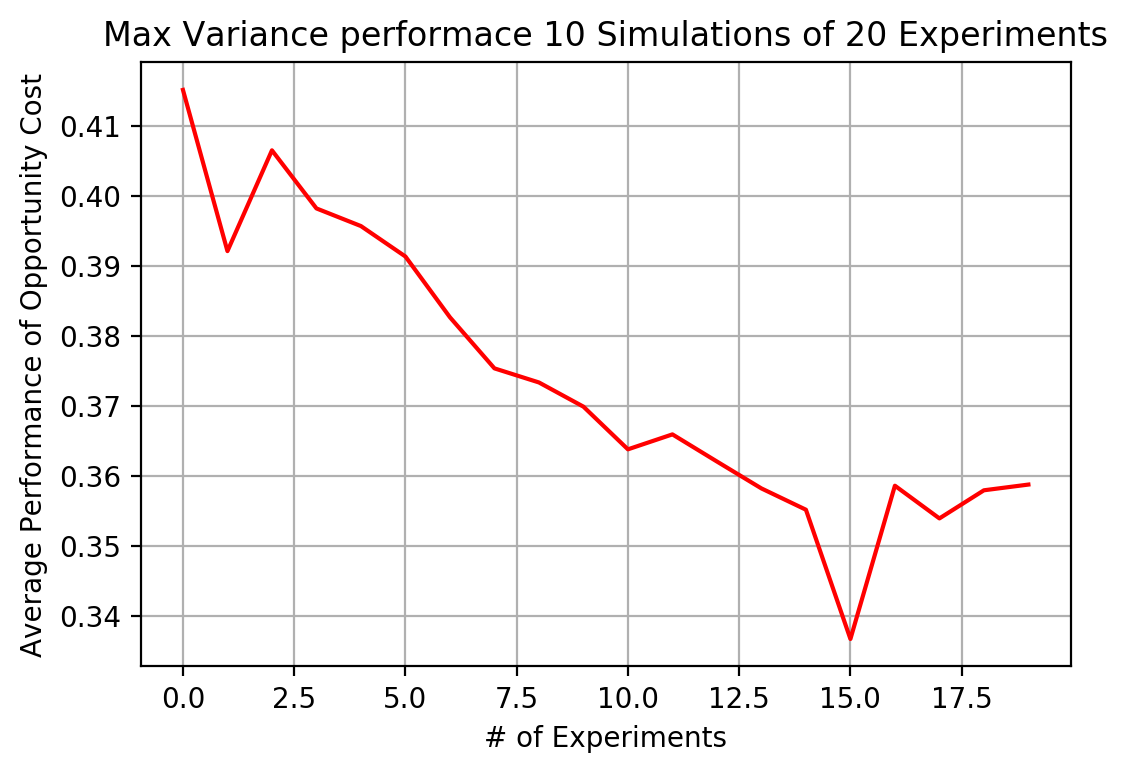

In [76]:
average_performance = np.mean(oc, axis = 0)

assert(len(average_performance)== 20)

plt.plot(average_performance, label = oc, color = 'r')


plt.title('Max Variance performace 10 Simulations of 20 Experiments')
plt.xlabel('# of Experiments')
plt.ylabel('Average Performance of Opportunity Cost')
plt.grid()



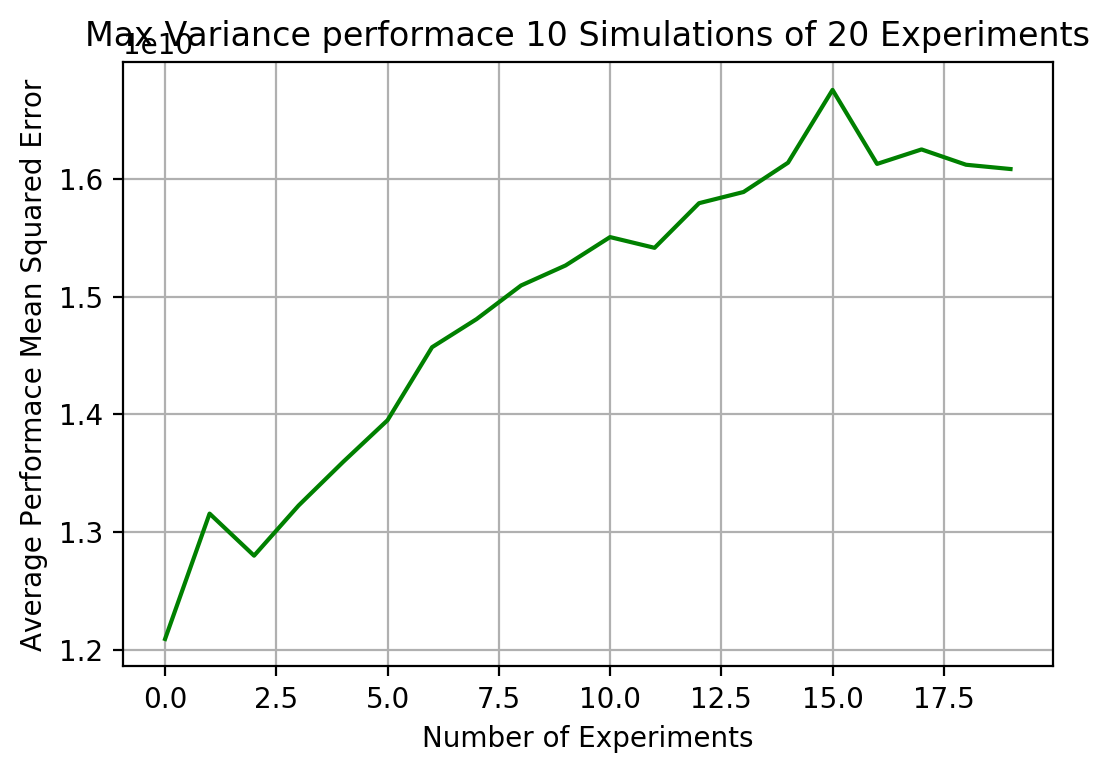

In [77]:
average_performance1 = np.mean((MSE**2), axis = 0)

assert(len(average_performance1)== 20)

plt.plot(average_performance1, label = MSE, color = 'g')

#plt.plot(n,average_performance1)
plt.title('Max Variance performace 10 Simulations of 20 Experiments')
plt.xlabel('Number of Experiments')
plt.ylabel('Average Performace Mean Squared Error')
plt.grid()


In [36]:
OX = X

NX = np.append(arr = X, values = obvs)

print(NX)

[ 700.          900.         1000.          751.26499496]


In [37]:
Oy = y

Ny = np.append(arr = y, values = x_n)

print(Ny)

[ 10. 100. 400.  75.]


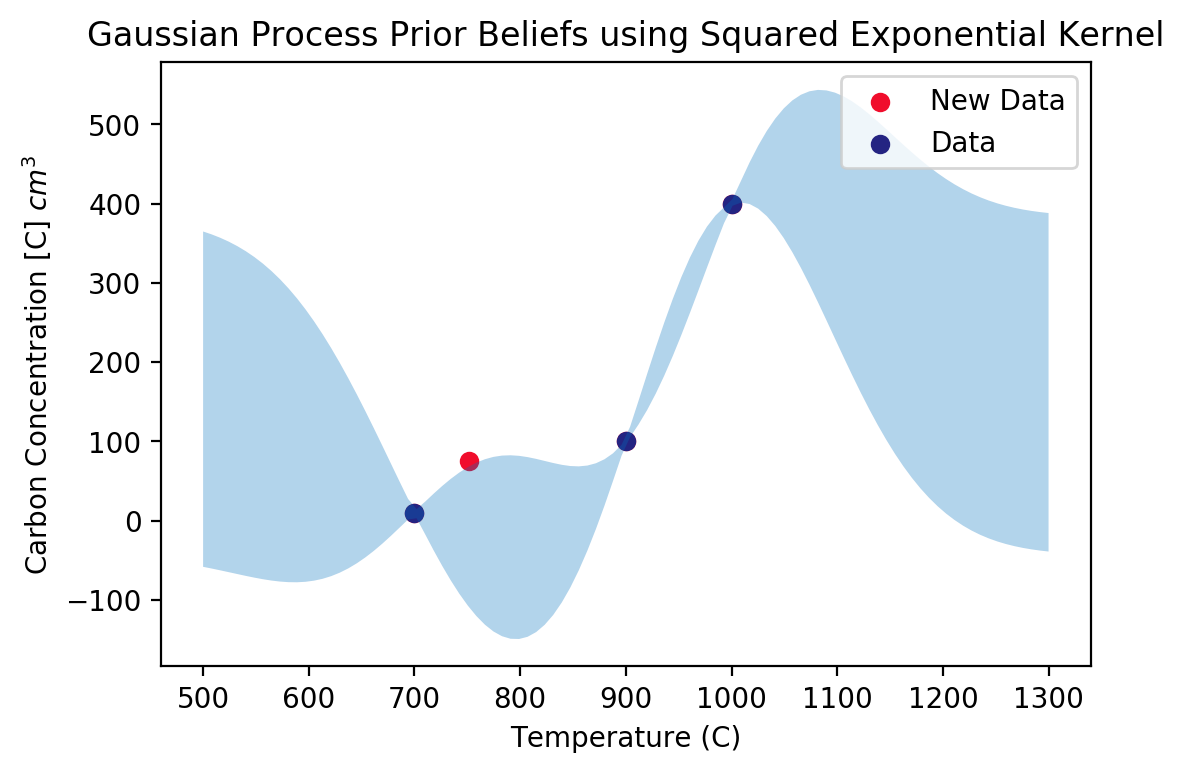

In [38]:
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
    
x_test = np.linspace(500, 1300, 100)


model.fit(NX[:, np.newaxis], Ny)
# squared exponential kernel
kernel = sigma_0**2*RBF(length_scale, length_scale_bounds = (100,1e4))

# normalized y confirms mean is = zero

model = GaussianProcessRegressor(kernel = kernel, alpha = sigma_W, normalize_y = True)

model.fit(x_data[:, np.newaxis], y_data,)

y_test, err = model.predict(x_test[:, np.newaxis], return_std = True)



plt.scatter(NX [:, np.newaxis], Ny, label = 'New Data')
plt.scatter(x_data,y_data, label='Data')
plt.fill_between(x_test, y_test +err, y_test - err, alpha = .3)
plt.xlabel('Temperature (C)')
plt.ylabel('Carbon Concentration [C] $cm^3$')
plt.title('Gaussian Process Prior Beliefs using Squared Exponential Kernel')
plt.legend()
plt.show()  



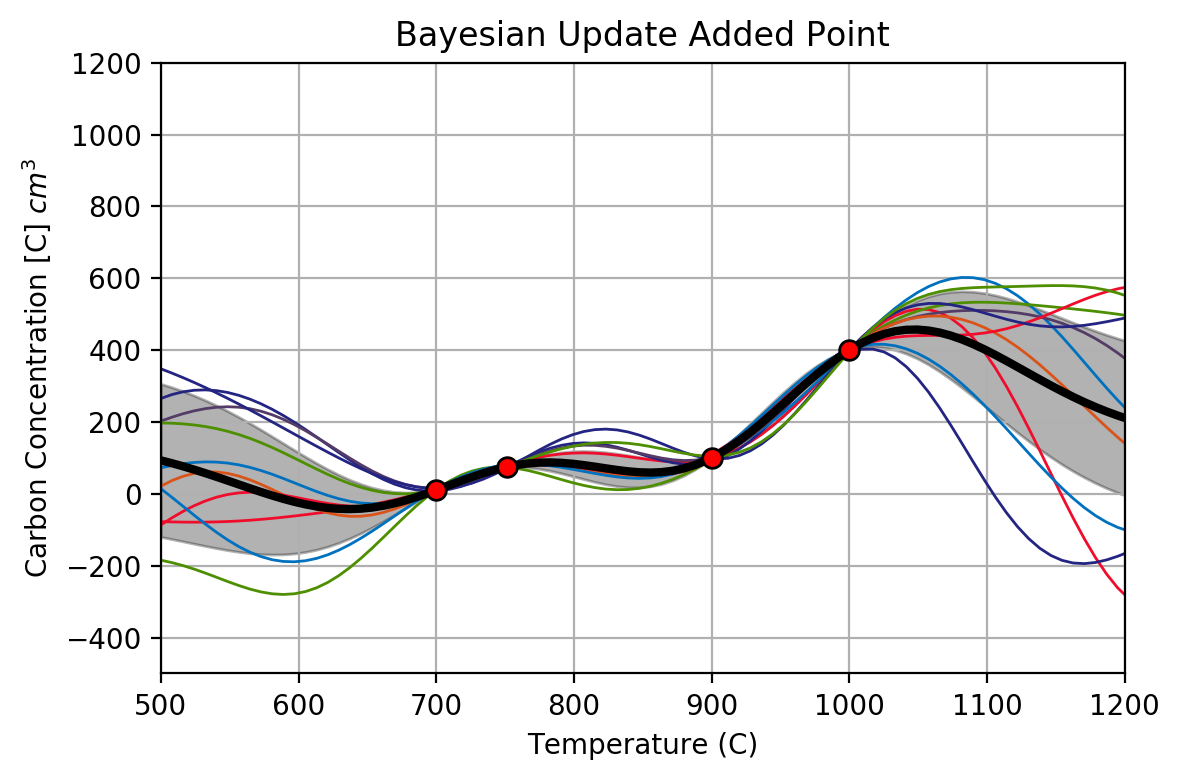

[ 700.          900.         1000.          751.26499496] [ 10. 100. 400.  75.]


In [39]:
from sklearn.gaussian_process.kernels import RBF
kernels = [178**2* RBF(length_scale=100, length_scale_bounds=(100, 1e4))]
for kernel in kernels:
    
    model = GaussianProcessRegressor(kernel = kernel, alpha = sigma_W, normalize_y = True)
        
    # Plot posterior
    
    
    
    x_test = np.linspace(500, 1300, 100)
    plt.grid()
    model.fit(NX[:, np.newaxis], Ny)
    
    #sampling from prior
    y_samples = model.sample_y(x_test[:, np.newaxis], 10)
    
    y_mean, y_std = model.predict(x_test[:, np.newaxis], return_std=True)
    
    plt.plot(x_test, y_samples, lw=1)
    plt.scatter(NX, Ny, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.plot(x_test, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(x_test, y_mean - y_std, y_mean + y_std,
                     alpha=0.3, color='k')

    plt.xlim(500, 1200)
    plt.ylim(-500, 1200)
    plt.xlabel('Temperature (C)')
    plt.ylabel('Carbon Concentration [C] $cm^3$')
    plt.title("Bayesian Update Added Point")
              
    plt.tight_layout()

plt.show()
print (NX, Ny)


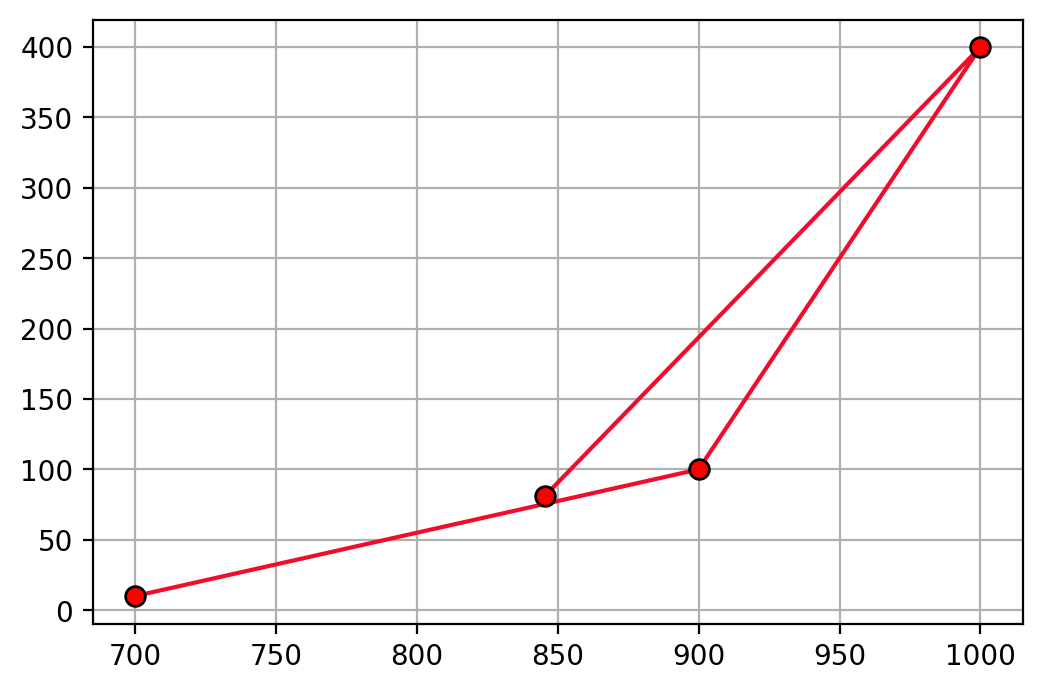

In [85]:
plt.scatter(NX, Ny, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.plot(NX, Ny)
plt.grid()


In [54]:
# Simulation
#Ei Policy
# loop over policy

# Data GP
B_0 = model.fit(x_data[:, np.newaxis], y_data,)


# for policy in policies:(B_n, f_truth)  
#for policy in policies:
    
oc = np.zeros([25, 20])
MSE = np.zeros([25,20])
num_mc_samples = 10
updates = np.zeros([10,20])

        # simulation loop
for s in range(25):
        x_test = np.linspace(500,1300,100)
        B_n = B_0
        sigma_n = sigma_0
        y_max = 400
        all_y = np.zeros(23)
        all_x = np.zeros(23)
        all_y[0]= 1e18/1e17
        all_y[1] =1e19/1e17
        all_y[2] =4e19/1e17
        all_x[0] =700
        all_x[1]= 900
        all_x[2]= 1000
        
        # Ground truth from prior
        # sampling a function from posterior GP

        f_truth = model.sample_y(x_test[:, np.newaxis], 1)
        True_max = np.max(f_truth)
        #print(True_max)

            # at each step calculating the opportunuity cost
            #performance = np.zeros(20) 


            # campaign loop: loop over experiments

        for n in range (20):
            # finding ground truths from prior data
                
                f_n = B_n.predict(x_test[:, np.newaxis])
                all_B_n= []
                x_star_n = np.argmax(f_n)
                #print(x_star_n)
                
               
                # Opportunity cost function
                oc[s, n] = np.abs((True_max - f_truth[x_star_n])/True_max)
                
               
                #MSE function
                MSE[s, n] = np.mean(f_n -f_truth)**2
                
                
                

                # using EI function to get max score - policy
                
                MAx_variance = MCEI_Acquisition_function(x_test, B_n, y_std, num_mc_samples)
                x_n = np.argmax(MAx_variance)
                print(x_n)
                
               
            
              

                # Calculate policy performance metrics:
                # MSE - global
                # opportunity cost
                
                #performace1[s, n] = Calculate_performace(B_n , f_truth)
                #performace2[s, n] = Calculate_performace(B_n , f_truth)

            # Experiment
                obvs = f_truth[x_n] + np.random.normal(0,sigma_n)
                if obvs > y_max:
                    y_max = obvs
                all_x[n+3] = x_n
                all_y[n+3] = obvs
                 
                    
            # update beliefs based on the GP
                B_n = GaussianProcessRegressor(kernel = kernel, alpha = sigma_W, normalize_y = True)
                #B_n = updates(B_n, x_n, obvs)
                
                B_n.fit(all_x[:n+3+1, np.newaxis], all_y[:n+3+1])
                
                # 1 new point appended
                #all_B_n.append(x_n)
                
                #all_B_n.append(obvs)
                
                
                # new model fit
                
    # average performace will have length 20 - average performace at each step
#B_n.fit(X[:, np.newaxis], y),(x_n,obvs)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

0.3565049891497892


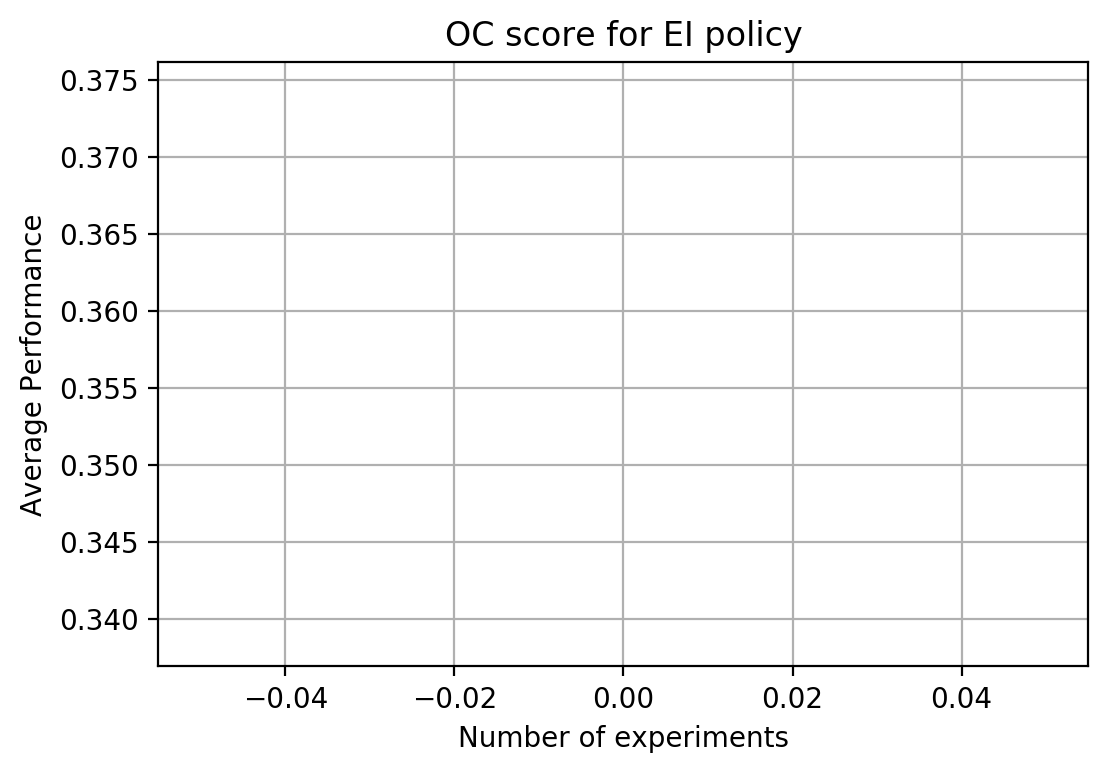

In [108]:
# oc Score calculation
print(np.mean(oc))
plt.plot (np.mean(oc))
plt.title('OC score for EI policy')
plt.ylabel('Average Performance')
plt.xlabel('Number of experiments')
plt.grid()

#Takes about 10 experiements to find the max value.


Text(0, 0.5, 'Opportunity Cost')

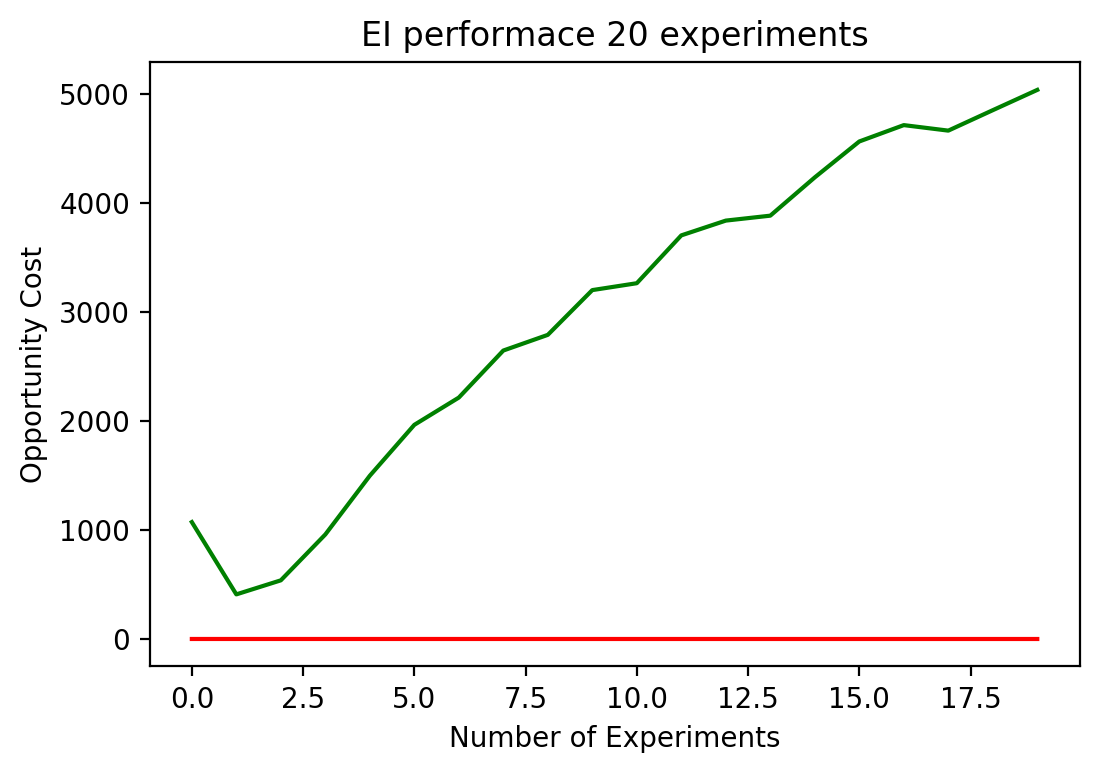

In [110]:
# Tells us what policy we need to run and how many experiments until we reach maximum value
#n =[x for x in range(1,21)]

    
average_performance = np.mean(oc, axis = 0)

#print(average_performance)

average_performance1 = np.mean(MSE, axis = 0)

#print(average_performance1)

assert(len(average_performance)== 20)



plt.plot(average_performance, label = oc, color='r')
plt.plot(average_performance1, label = MSE, color = 'g')

#plt.plot(n,average_performance1)
plt.title('EI performace 20 experiments')
plt.xlabel('Number of Experiments')
plt.ylabel('Opportunity Cost')



# Knowledge Gradient

# Max Variance

# Exploration

# Exploitations